# 08. PyTorch Paper Replication

In this project, we're going to replicate a ML research paper and creating a Vision Transformer (ViT) from scratch using PyTorch.


The goal of paper replicating is to replicate the ML advances with code so that the techniques can be used for our own problem.

Contents of a machine learning research paper can vary from paper to paper but they generally follow this structure

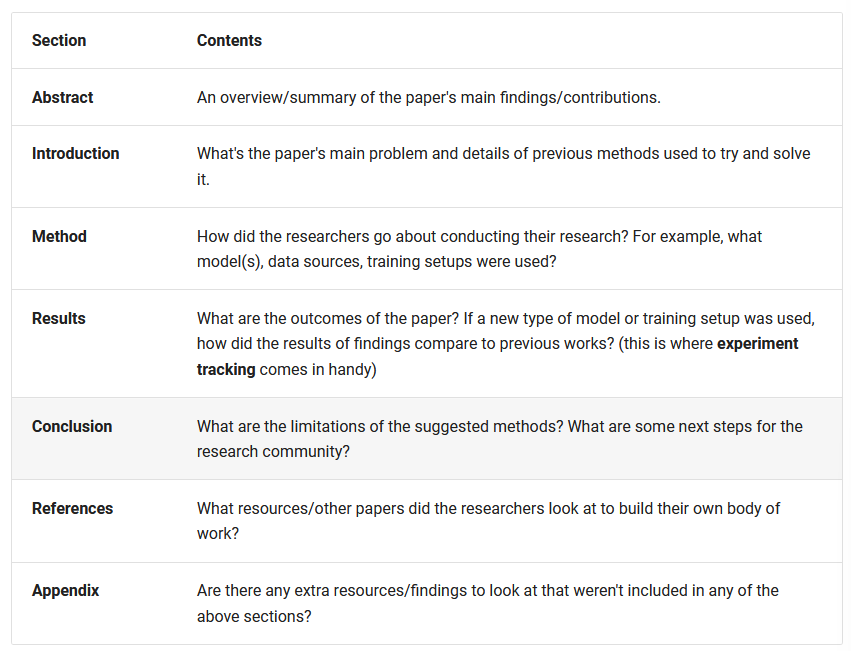

## Places to find code examples of ML research papers.

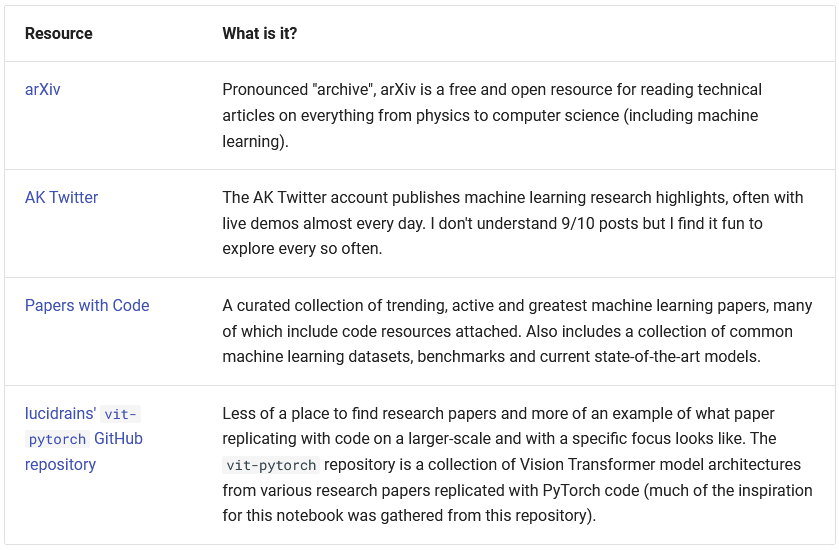

we're going to be replicating the machine learning research paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (https://arxiv.org/abs/2010.11929) with PyTorch

The Transformer neural network architecture was originally introduces in the machine learning research paper Attention is all you need (https://arxiv.org/abs/1706.03762).

Original Transformer Architecutre was designed to work on 1D sequence of text.

A transformer architecture is generally considered to be any neural network that uses the attention mechanism as its primary learning layer. Similar to how a convolutional neural network uses convolutions as its primary learning layer.



The Vision transformer (ViT) architecture was designed to adapt the original transformer architecture to vision problem(s) (classification being the first and since then many others have followed).


We will replicate the first Vision transformer architecture (the orignial).

## 0. Getting setup

import modules and libraries

In [36]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [37]:
# set device

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get the data

In [38]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [39]:
train_dir = image_path/ "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

now that we have data lets turn it into `DataLoader`'s.

In table 3, of paper the training res (img size) is mentioned as 224 (h,w)

### 2.1 Prepare transform for images

In [40]:
# hyper param for img size
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"The Manual transform: {manual_transforms}")

The Manual transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

The paper states the use of a batch size of 4096 which is 128x the size of what we used in past.

lets stick with 32 since 4096 is significantly large

In [41]:
BATCH_SIZE = 32 # hyper param 

train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir, 
    test_dir = test_dir,
    transform= manual_transforms,
    batch_size= BATCH_SIZE,
    num_workers= 0
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2d56eae3820>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

Lets look at 1 image from dataset (important because we are going to have to make patches from what we have seen in the paper)

In [42]:
image_batch , label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

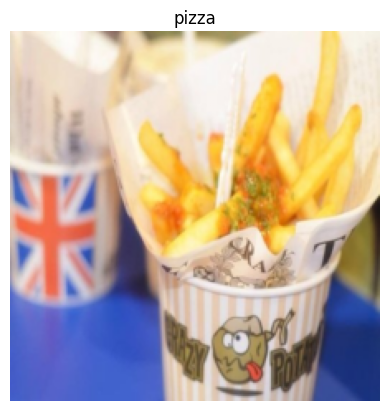

In [43]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper: an overview


### 3.1 Inputs and outputs, layers and blocks

* Layer - takes an input, performs a function on it, returns an output.

* Block - a collection of layers, takes and input, performs a series of function on it, returns an output.

* Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.




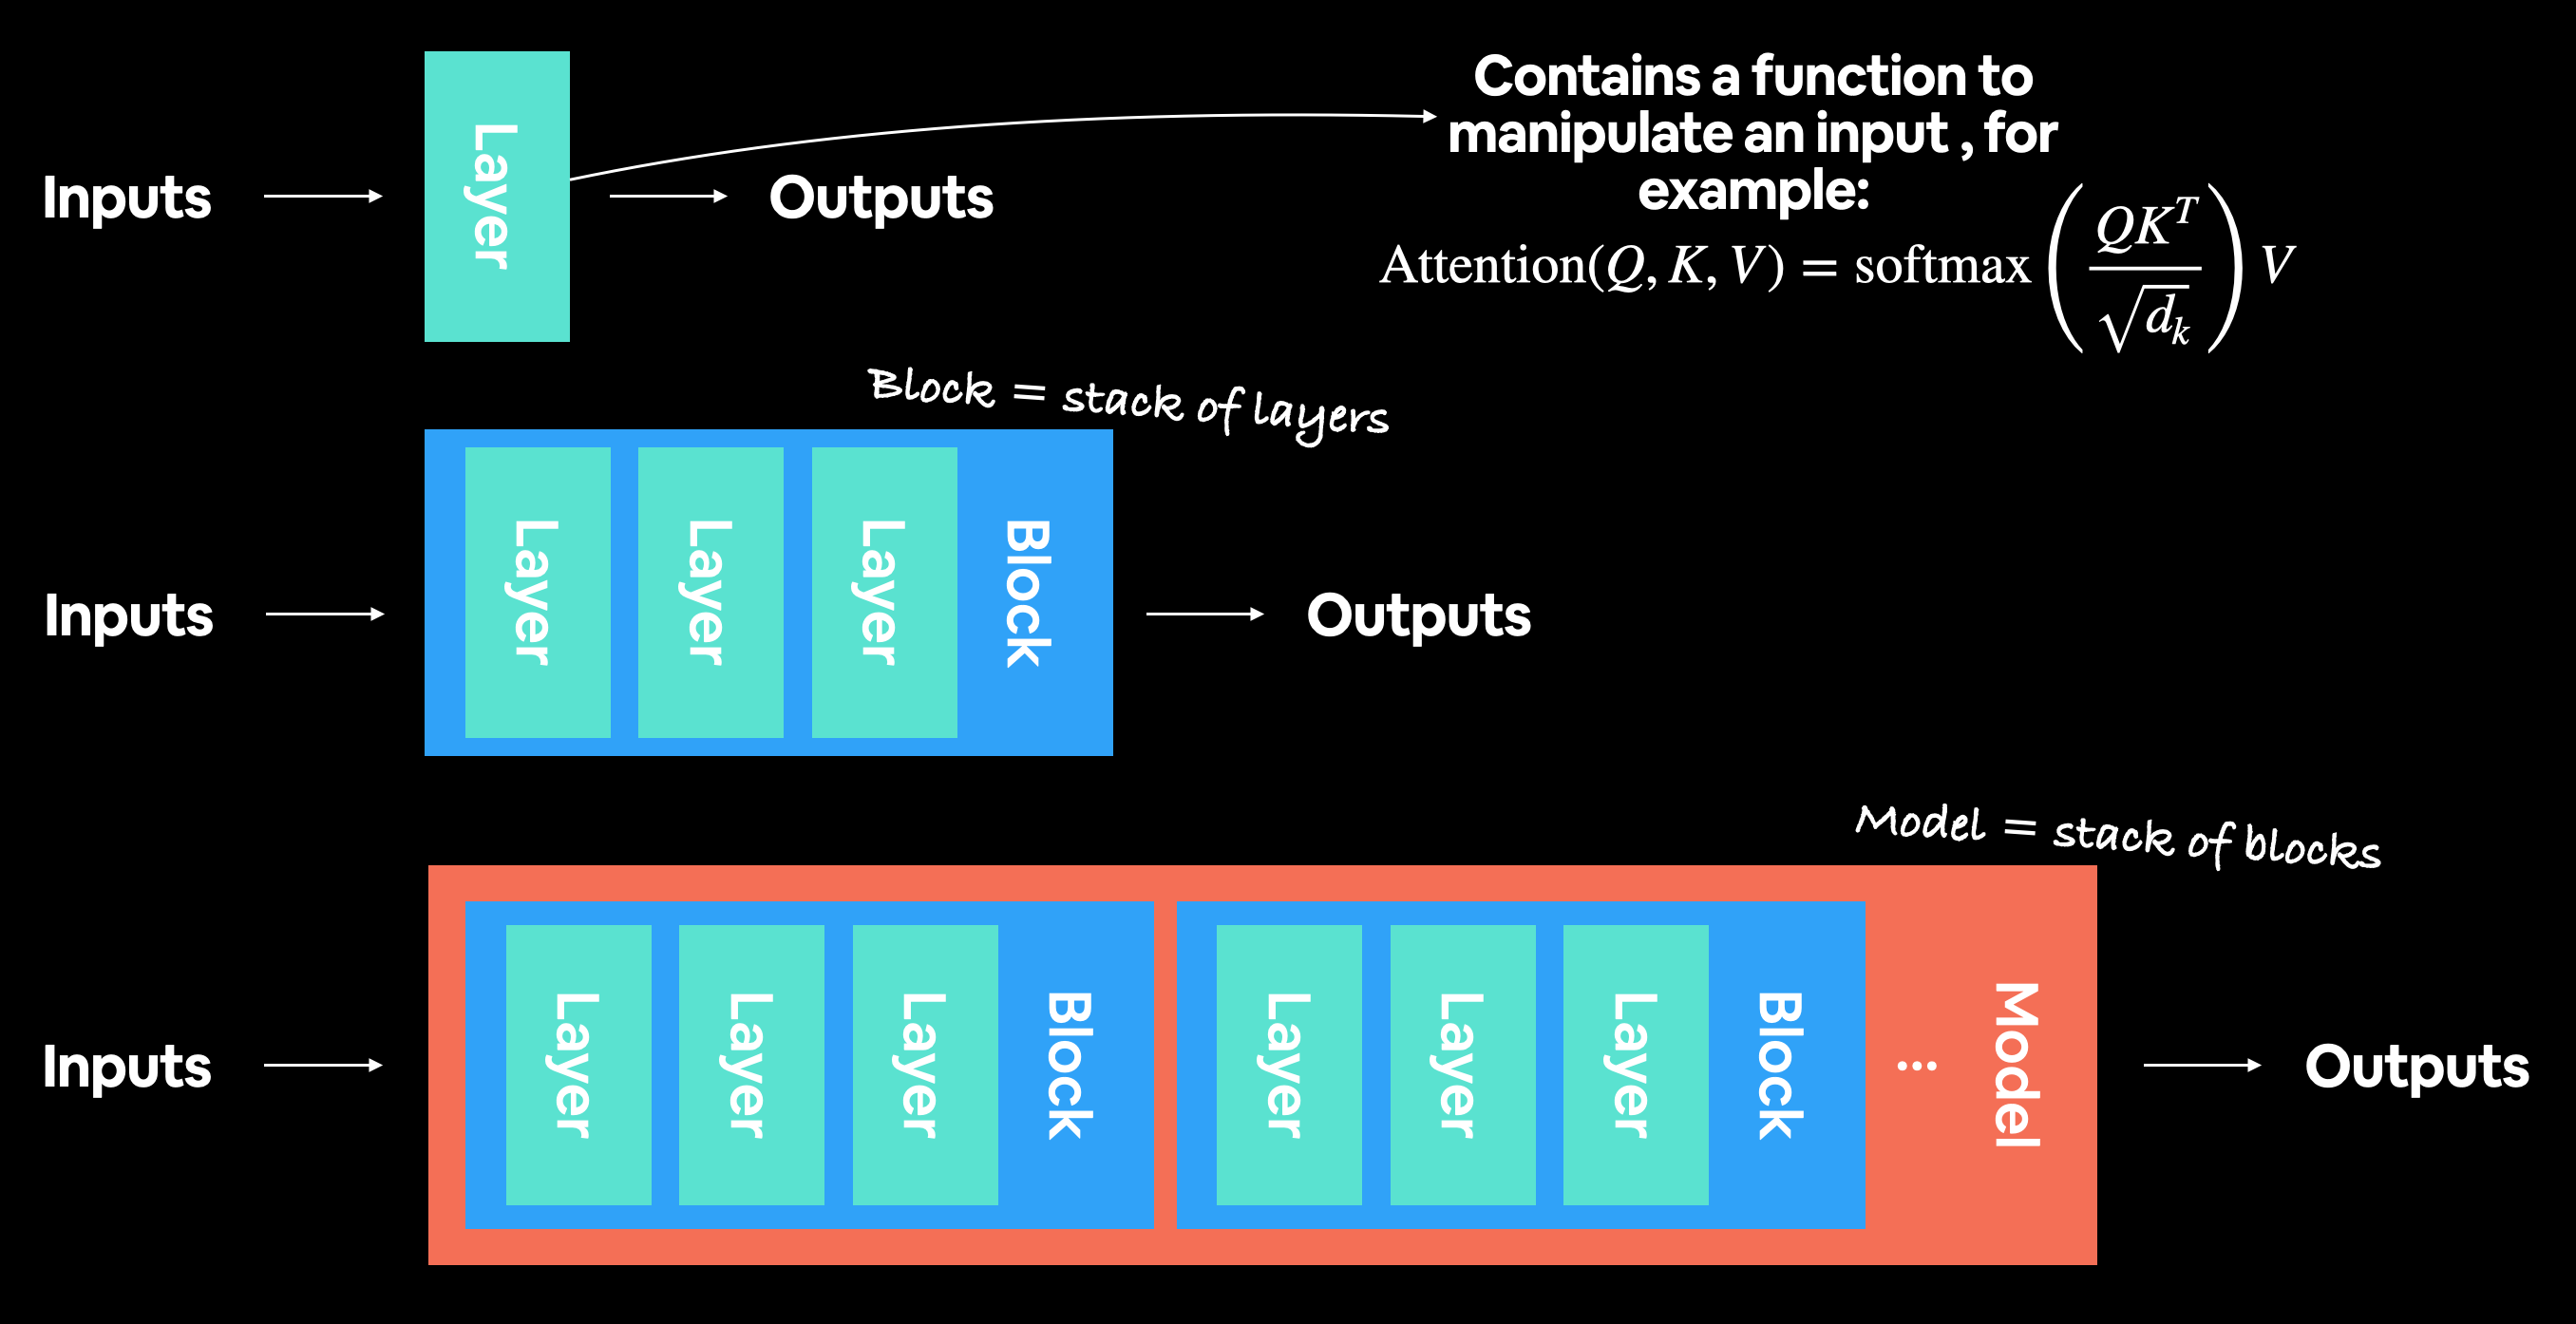

### 3.2 What's ViT made of?

1. Figure - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.

2. Four Equations in section 3.1 - These equations give a little bit more of a mathematical grounding to the color block in fig 1.

3. Table 1 - This table shows this various hyperparameter settings (no of layers and no of hidden units) for ViT model variants. We'll be focused on the smallest version, ViT - Base.

#### 3.2.1 Exploring Figure 1

1. **Layers**- takes an input, performs an operation or function on the input, produces an output.
2. **Blocks**- a collection of layers, which in turn also takes an input and produces and output.
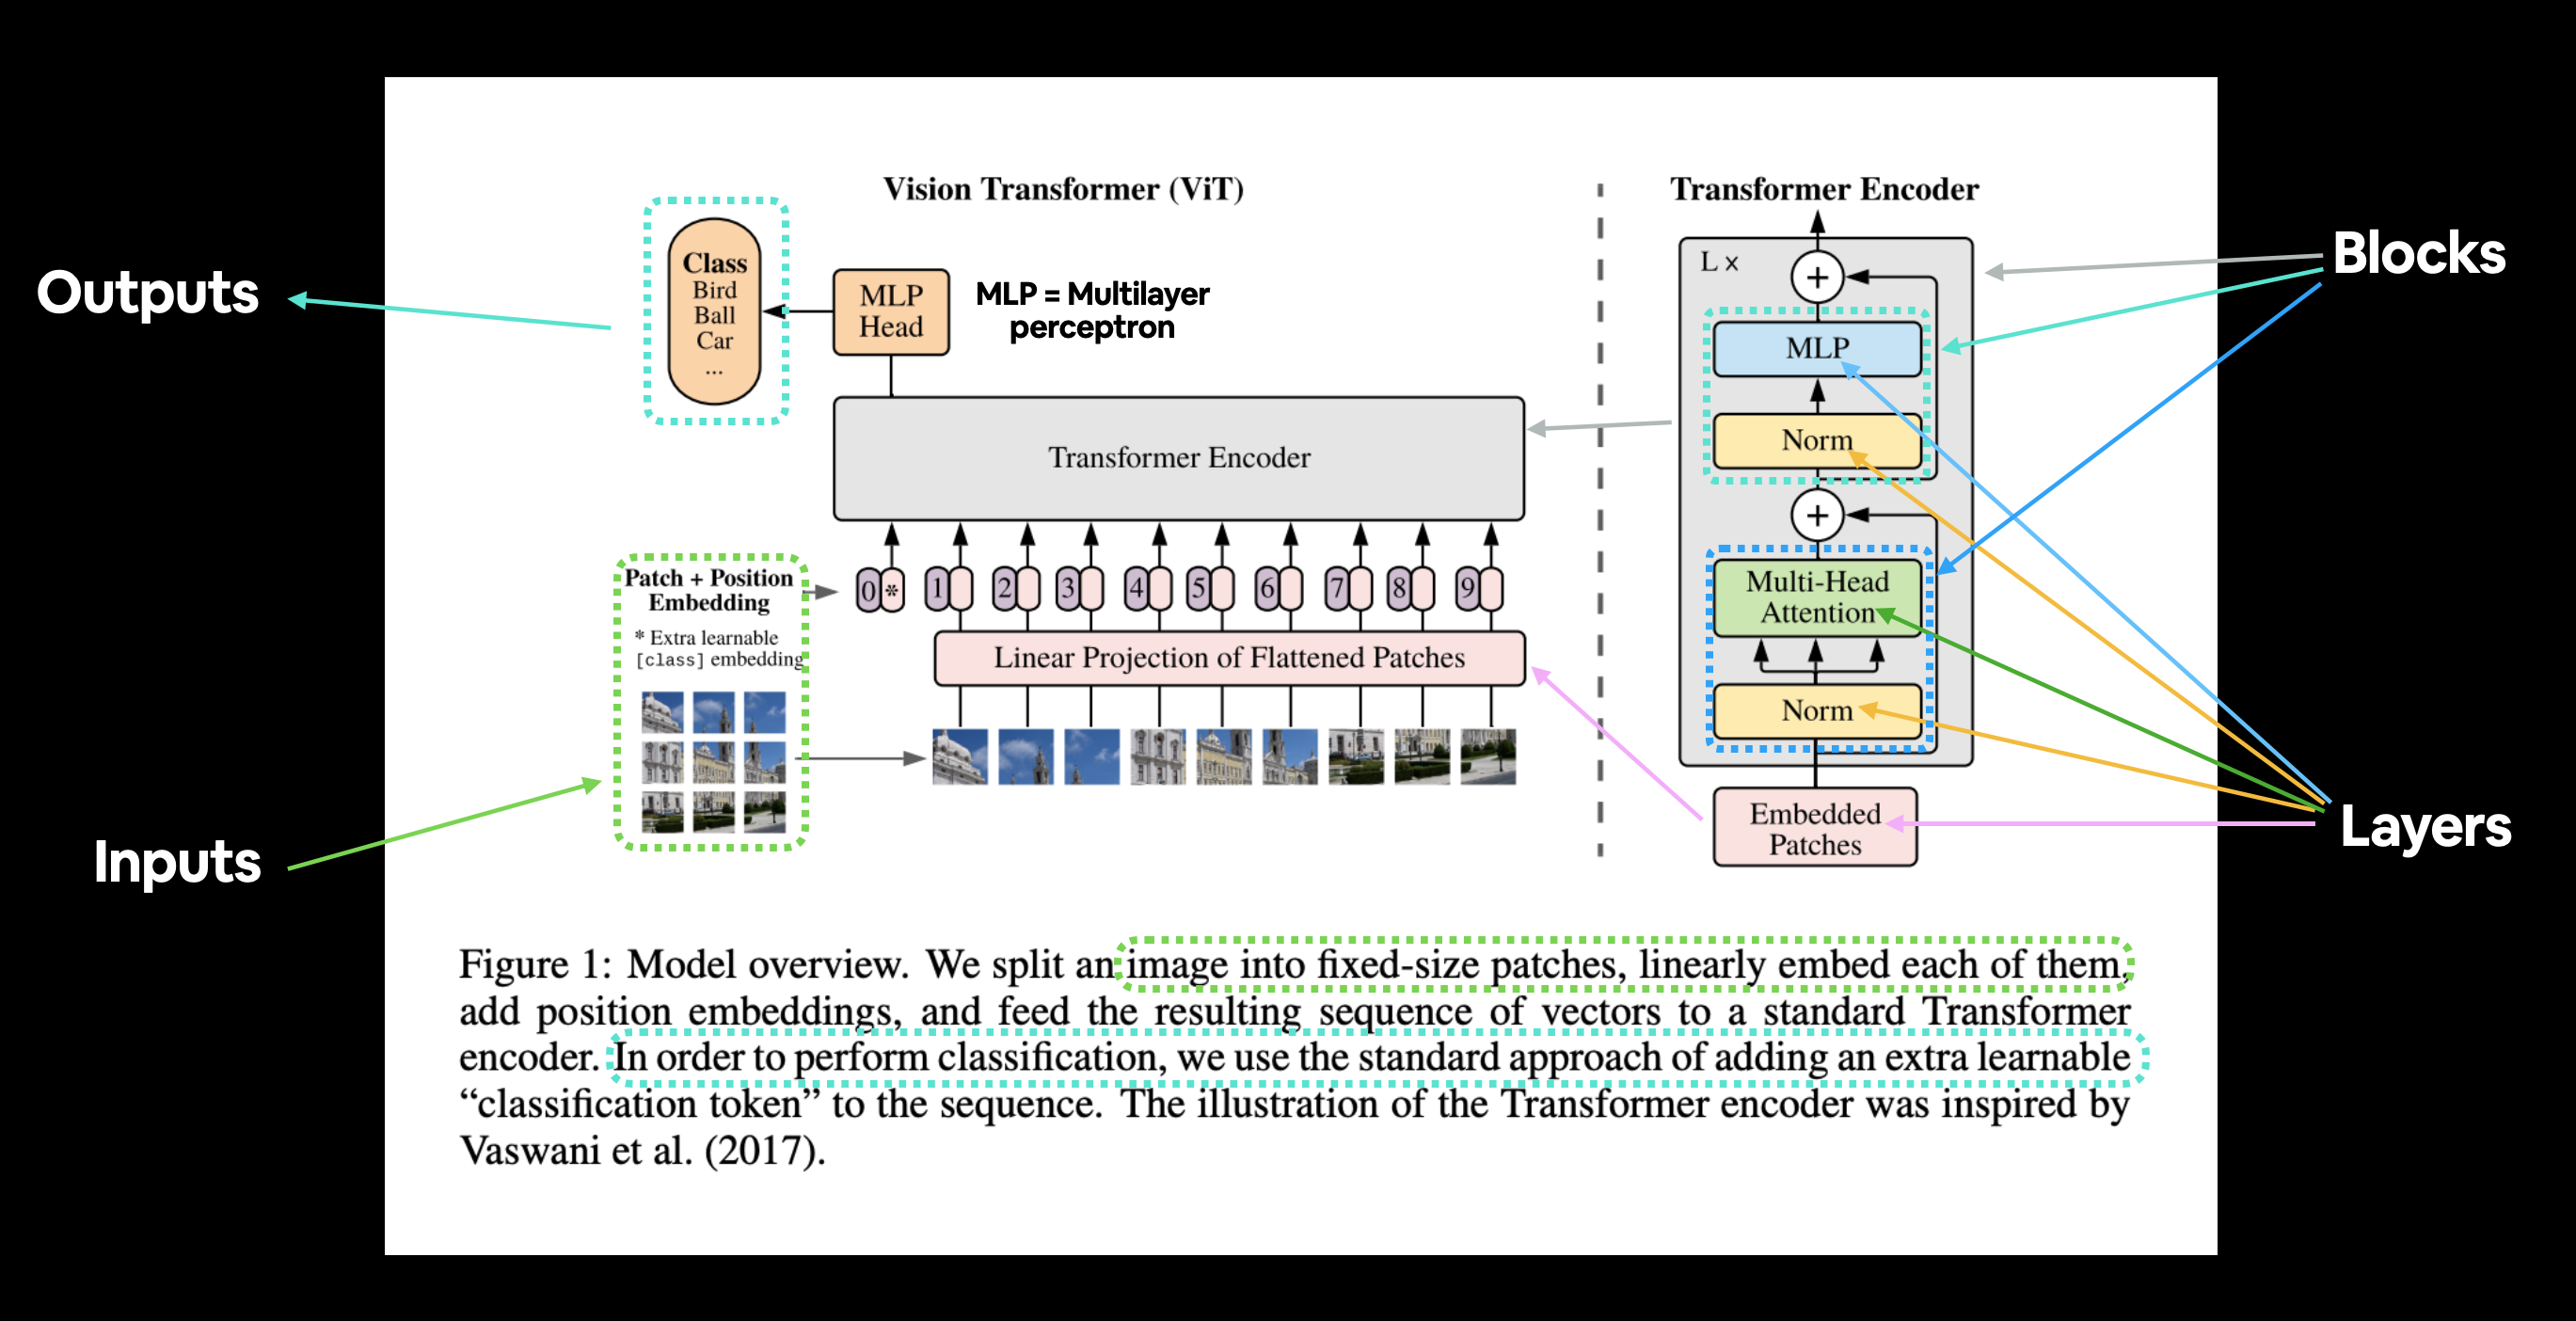


The ViT architecture is comprised of several stages:

* **Patch + Position Embedding(input)** - turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.

* **Linear Projection of flattened patches (Embedded Patches)**- The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.

* **Norm**- This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.

* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().

* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).

* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.

* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### 3.2.1 Equation 1 overview


$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

Where each of the elements in the vector is learnable (their requires_grad=True).

#### 3.2.2 Equation 2 overview

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection.

We'll call this layer the "MSA block".

In pseudocode, this might look like:

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.2 Equation 3 overview


$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.2 Equation 4 overview

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of x_output_MLP_block:

y = Linear_layer(LN_layer(x_output_MLP_block[0]))

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

## 4. Equation 1 --- Splitting and embedding the patches.


*    $D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.
*    The image starts as 2D with size ${H \times W \times C}$.
     *   $(H, W)$ is the resolution of the original image (height, width).
      *  $C$ is the number of channels.
 *   The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
      *  $(P, P)$ is the resolution of each image patch (patch size).
      *  $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.


For 16 (ViT base) the patch size is 16.

### 4.1 calculating embedded input output shape

In [44]:
# Calculate the number of patches
height = 224
width = 224
color_channels = 3
patch_size = 16

n = (height * width)/ (patch_size)**2
n = int(n)

print(f"The number of patches we get is : {n}")

The number of patches we get is : 196


In [45]:
print(f"The Embedded output is: {n, (patch_size**2)*color_channels}")

The Embedded output is: (196, 768)


### 4.2 turn single image into patches


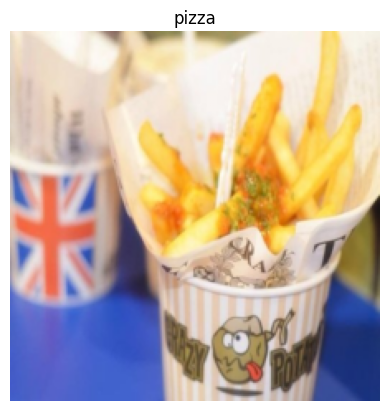

In [46]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

(-0.5, 223.5, 15.5, -0.5)

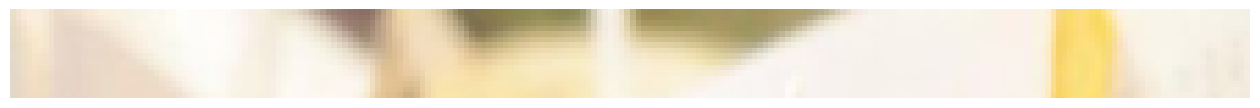

In [47]:
image_permuted = image.permute(1,2,0) # to make compatible with matplotlib

patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);
plt.axis(False)

No. of Patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


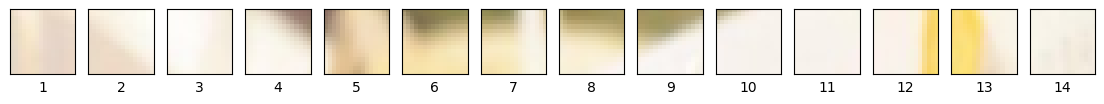

In [48]:
# Setup hyper params + make sure patch size matches with img size
img_size = 224
patch_size = 16
num_patch = img_size/patch_size

assert img_size % patch_size == 0, "Improper image size please fix"
print(f"No. of Patches per row: {num_patch}\nPatch Size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = 1,
                       ncols = img_size // patch_size,
                       figsize = (num_patch, num_patch),
                       sharex = True,
                       sharey = True)

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch : patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

No. of Patches per row: 14.0
Patch Size: 16 pixels x 16 pixels


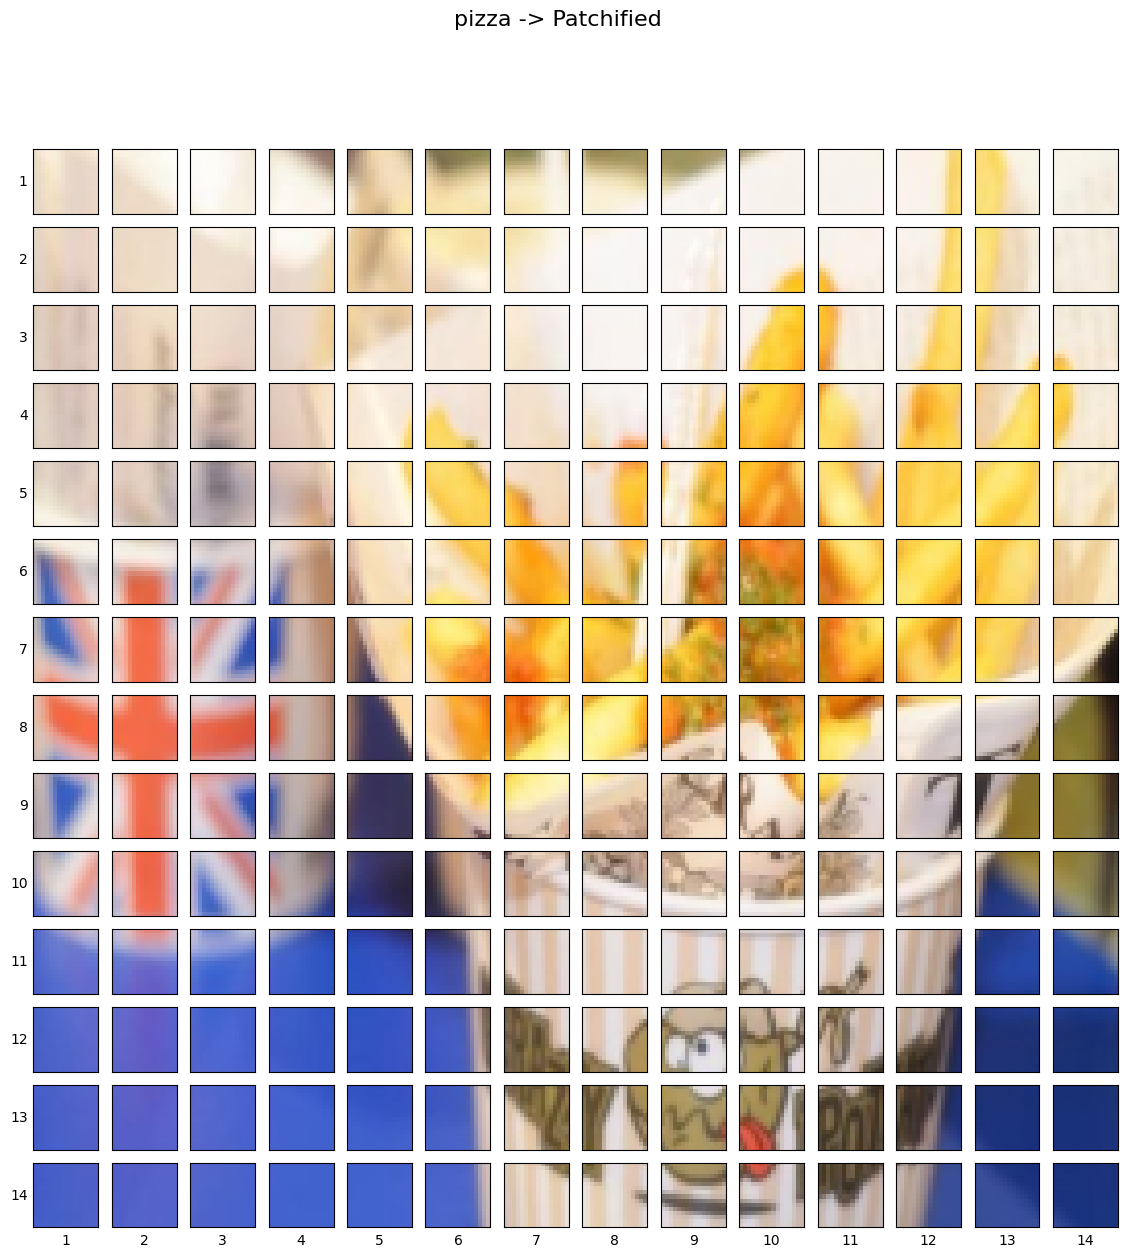

In [49]:
# Setup hyper params + make sure patch size matches with img size
img_size = 224
patch_size = 16
num_patch = img_size/patch_size

assert img_size % patch_size == 0, "Improper image size please fix"
print(f"No. of Patches per row: {num_patch}\nPatch Size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = img_size // patch_size,
                       ncols = img_size // patch_size,
                       figsize = (num_patch, num_patch),
                       sharex = True,
                       sharey = True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0,img_size,patch_size)):
        axs[i,j].imshow(image_permuted[patch_height: patch_height+patch_size,  # iterates through the height
                                       patch_width : patch_width + patch_size, # iterates through the width
                                       :]); # get all color channels
        axs[i,j].set_ylabel(i+1,
                            rotation = "horizontal",
                            horizontalalignment = "right",
                            verticalalignment = "center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

# 1 title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 16)
plt.show()

### 4.3 Creating patches using `torch.nn.conv2d()`

We've seen what an image looks like when it gets turned into patches, but this way is very hectic.

let's start moving towards replicating the patch embedding layer with PyTorch.

the authors of the ViT paper mention that the patch embedding is achievable with a convolutional neural network(CNN):

by setting the `kernel_size` and `stride` parameters of a `torch.nn.Conv2d()` layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

* input - (224,224,3)
* output - (196, 768)

In [50]:
from torch import nn

patch_size = 16 

conv2d = nn.Conv2d(3,
                   768,
                   patch_size,
                   patch_size,
                   padding= 0)

In [51]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add 1 single batch
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [291, 671, 725, 188, 514]


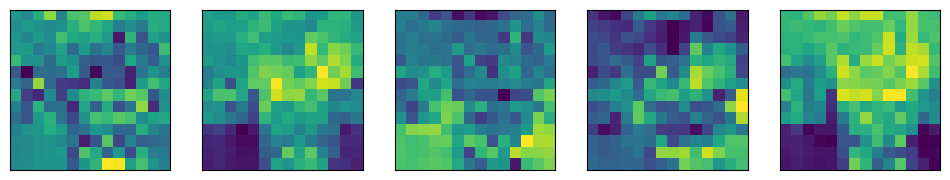

In [52]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);




these are the features layer has learned and a key point here is that they may change over time as our nn learns

this means it can be considered a learnable embedding of our image

In [53]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.6635, 0.7267, 0.7521, 0.6843, 0.6235, 0.5492, 0.6368, 0.5823,
           0.5957, 0.7418, 0.7372, 0.6895, 0.7016, 0.7273],
          [0.6424, 0.6535, 0.6928, 0.6963, 0.5546, 0.6224, 0.7060, 0.7485,
           0.7535, 0.7629, 0.7293, 0.7034, 0.6792, 0.6972],
          [0.6063, 0.5980, 0.6658, 0.6394, 0.6449, 0.6997, 0.7238, 0.7457,
           0.7367, 0.5407, 0.6806, 0.5998, 0.6568, 0.6946],
          [0.6085, 0.5867, 0.5408, 0.6170, 0.6903, 0.7242, 0.6923, 0.7552,
           0.6494, 0.4372, 0.7147, 0.4572, 0.6186, 0.7163],
          [0.6551, 0.5708, 0.4930, 0.5886, 0.7125, 0.5401, 0.5942, 0.5661,
           0.6125, 0.3578, 0.5600, 0.4911, 0.5517, 0.6902],
          [0.5149, 0.6164, 0.5256, 0.3799, 0.6186, 0.5562, 0.4546, 0.4708,
           0.5419, 0.3468, 0.4447, 0.5475, 0.5263, 0.6090],
          [0.5007, 0.4832, 0.4592, 0.4563, 0.3970, 0.5455, 0.3371, 0.4351,
           0.3056, 0.2963, 0.3846, 0.4034, 0.5256, 0.4265],
          [0.4896, 0.3751, 0.5060, 0.4533, 0.2286, 0.43

the `grad_fn` output of the `single_feature_map` and the `requires_grad = True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

### 4.4 Flattening the patch embedding

* desired output: (196, 768) -> (num of patches, embedding dimention) ->  ${N \times\left(P^{2} \cdot C\right)}$

In [54]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [55]:
# create flatten layer 
flatten = nn.Flatten(start_dim=2, # flatten feature map height
                     end_dim= 3) # flatten feature map width


Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


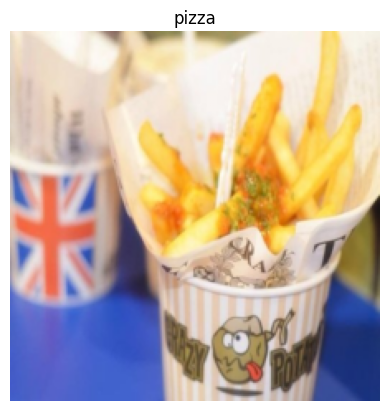

In [56]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")


image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

(-0.5, 195.5, 0.5, -0.5)

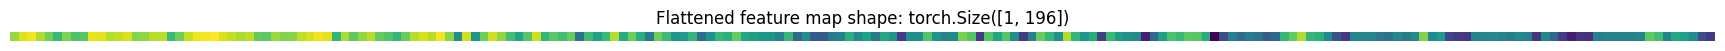

In [57]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [58]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.6635, 0.7267, 0.7521, 0.6843, 0.6235, 0.5492, 0.6368, 0.5823, 0.5957,
          0.7418, 0.7372, 0.6895, 0.7016, 0.7273, 0.6424, 0.6535, 0.6928, 0.6963,
          0.5546, 0.6224, 0.7060, 0.7485, 0.7535, 0.7629, 0.7293, 0.7034, 0.6792,
          0.6972, 0.6063, 0.5980, 0.6658, 0.6394, 0.6449, 0.6997, 0.7238, 0.7457,
          0.7367, 0.5407, 0.6806, 0.5998, 0.6568, 0.6946, 0.6085, 0.5867, 0.5408,
          0.6170, 0.6903, 0.7242, 0.6923, 0.7552, 0.6494, 0.4372, 0.7147, 0.4572,
          0.6186, 0.7163, 0.6551, 0.5708, 0.4930, 0.5886, 0.7125, 0.5401, 0.5942,
          0.5661, 0.6125, 0.3578, 0.5600, 0.4911, 0.5517, 0.6902, 0.5149, 0.6164,
          0.5256, 0.3799, 0.6186, 0.5562, 0.4546, 0.4708, 0.5419, 0.3468, 0.4447,
          0.5475, 0.5263, 0.6090, 0.5007, 0.4832, 0.4592, 0.4563, 0.3970, 0.5455,
          0.3371, 0.4351, 0.3056, 0.2963, 0.3846, 0.4034, 0.5256, 0.4265, 0.4896,
          0.3751, 0.5060, 0.4533, 0.2286, 0.4364, 0.4322, 0.5898, 0.4505, 0.4009,
          0.4214

### 4.5 Turning the ViT patch embedding layer into a PyTorch module


now we combine everything into a pytorch module

Specifically we'll:

1. Create a class that subclass nn.module
2. initialize with params `in_channels = 3`, `patch_size=16` and `embedding_dim=768`
3. Create a layer to turn image into patches using `nn.Conv2d()`
4. Create a layer to flatten the patch feature map into 1 dimension
5. define `forward()` to take an input and pass it through the layers.
6. Make sure output reflect output shape in the ViT architecture.

In [59]:
class PatchEmbedding(nn.Module):

    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768) -> None:
        super().__init__()

        self.patcher = nn.Conv2d(in_channels= in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim= 2, 
                                  end_dim= 3)
        

    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size not compatible ({image_resolution})"


        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

In [60]:
set_seeds()

patchify = PatchEmbedding(in_channels = 3,
                          patch_size= 16,
                          embedding_dim= 768)

print(f"Input image shape: {image.unsqueeze(0).shape}")

patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [61]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating the class token embedding



In [62]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [63]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
         [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
         ...,
         [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
         [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
         [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating the position embedding

this helps the architecture know which patch comes before and after a particular patch

In [64]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
          [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
          ...,
          [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
          [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
          [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where:

*    $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
*    $D$ is the size of the patch embeddings, different values for $D$ can be found in Table 1 (embedding dimension).


In [65]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [66]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.0633,  1.2304,  0.7579,  ...,  1.6643,  0.5666,  1.3613],
         [-0.0070,  1.2692,  0.8000,  ...,  1.7158,  0.5325,  1.3300],
         ...,
         [ 0.5643,  1.0886,  0.7734,  ...,  1.2279,  0.8812,  1.4053],
         [ 0.7328,  1.0792,  0.8235,  ...,  1.2662,  0.9245,  1.1098],
         [ 0.7778,  1.0906,  0.8685,  ...,  1.2308,  0.9384,  1.0505]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 putting it all together

replicating equation 1 from section 3.1 of the ViT paper:

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$


we can do so by:

1. Setting patch size
2. Getting single image, saving its h and w
3. adding batch so its compatible with our `PatchEmbedding` layer.
4. creating 1 instance of layer with in = 3, and out = 768
5. pass single image to layer to get patches.
6. Create class token 
7. prepending to patches.
8. creating position embedding
9. Adding position embedding to class token and patch embeddings.



In [67]:
set_seeds()
# 1. set patch size
patch_size = 16
# 2. store h , w
print(f"Image tensor shape: {image.shape}")
height , width = image.shape[1], image.shape[2]
# add batch data
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# create instance of layer
patch_embedding_layer = PatchEmbedding(in_channels= 3,
                                       patch_size= patch_size,
                                       embedding_dim=768)

# pass image through the layer
patch_embedding = patch_embedding_layer(x)

print(f"Embedding shape: {patch_embedding.shape}")

# create class token
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad= True)

# prepend class to patch embedding

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)

# creating position embedding
number_of_patches = int((height*width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),
                                  requires_grad= True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding

print(f"Final shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Embedding shape: torch.Size([1, 196, 768])
Final shape: torch.Size([1, 197, 768])


What each block signifies? 

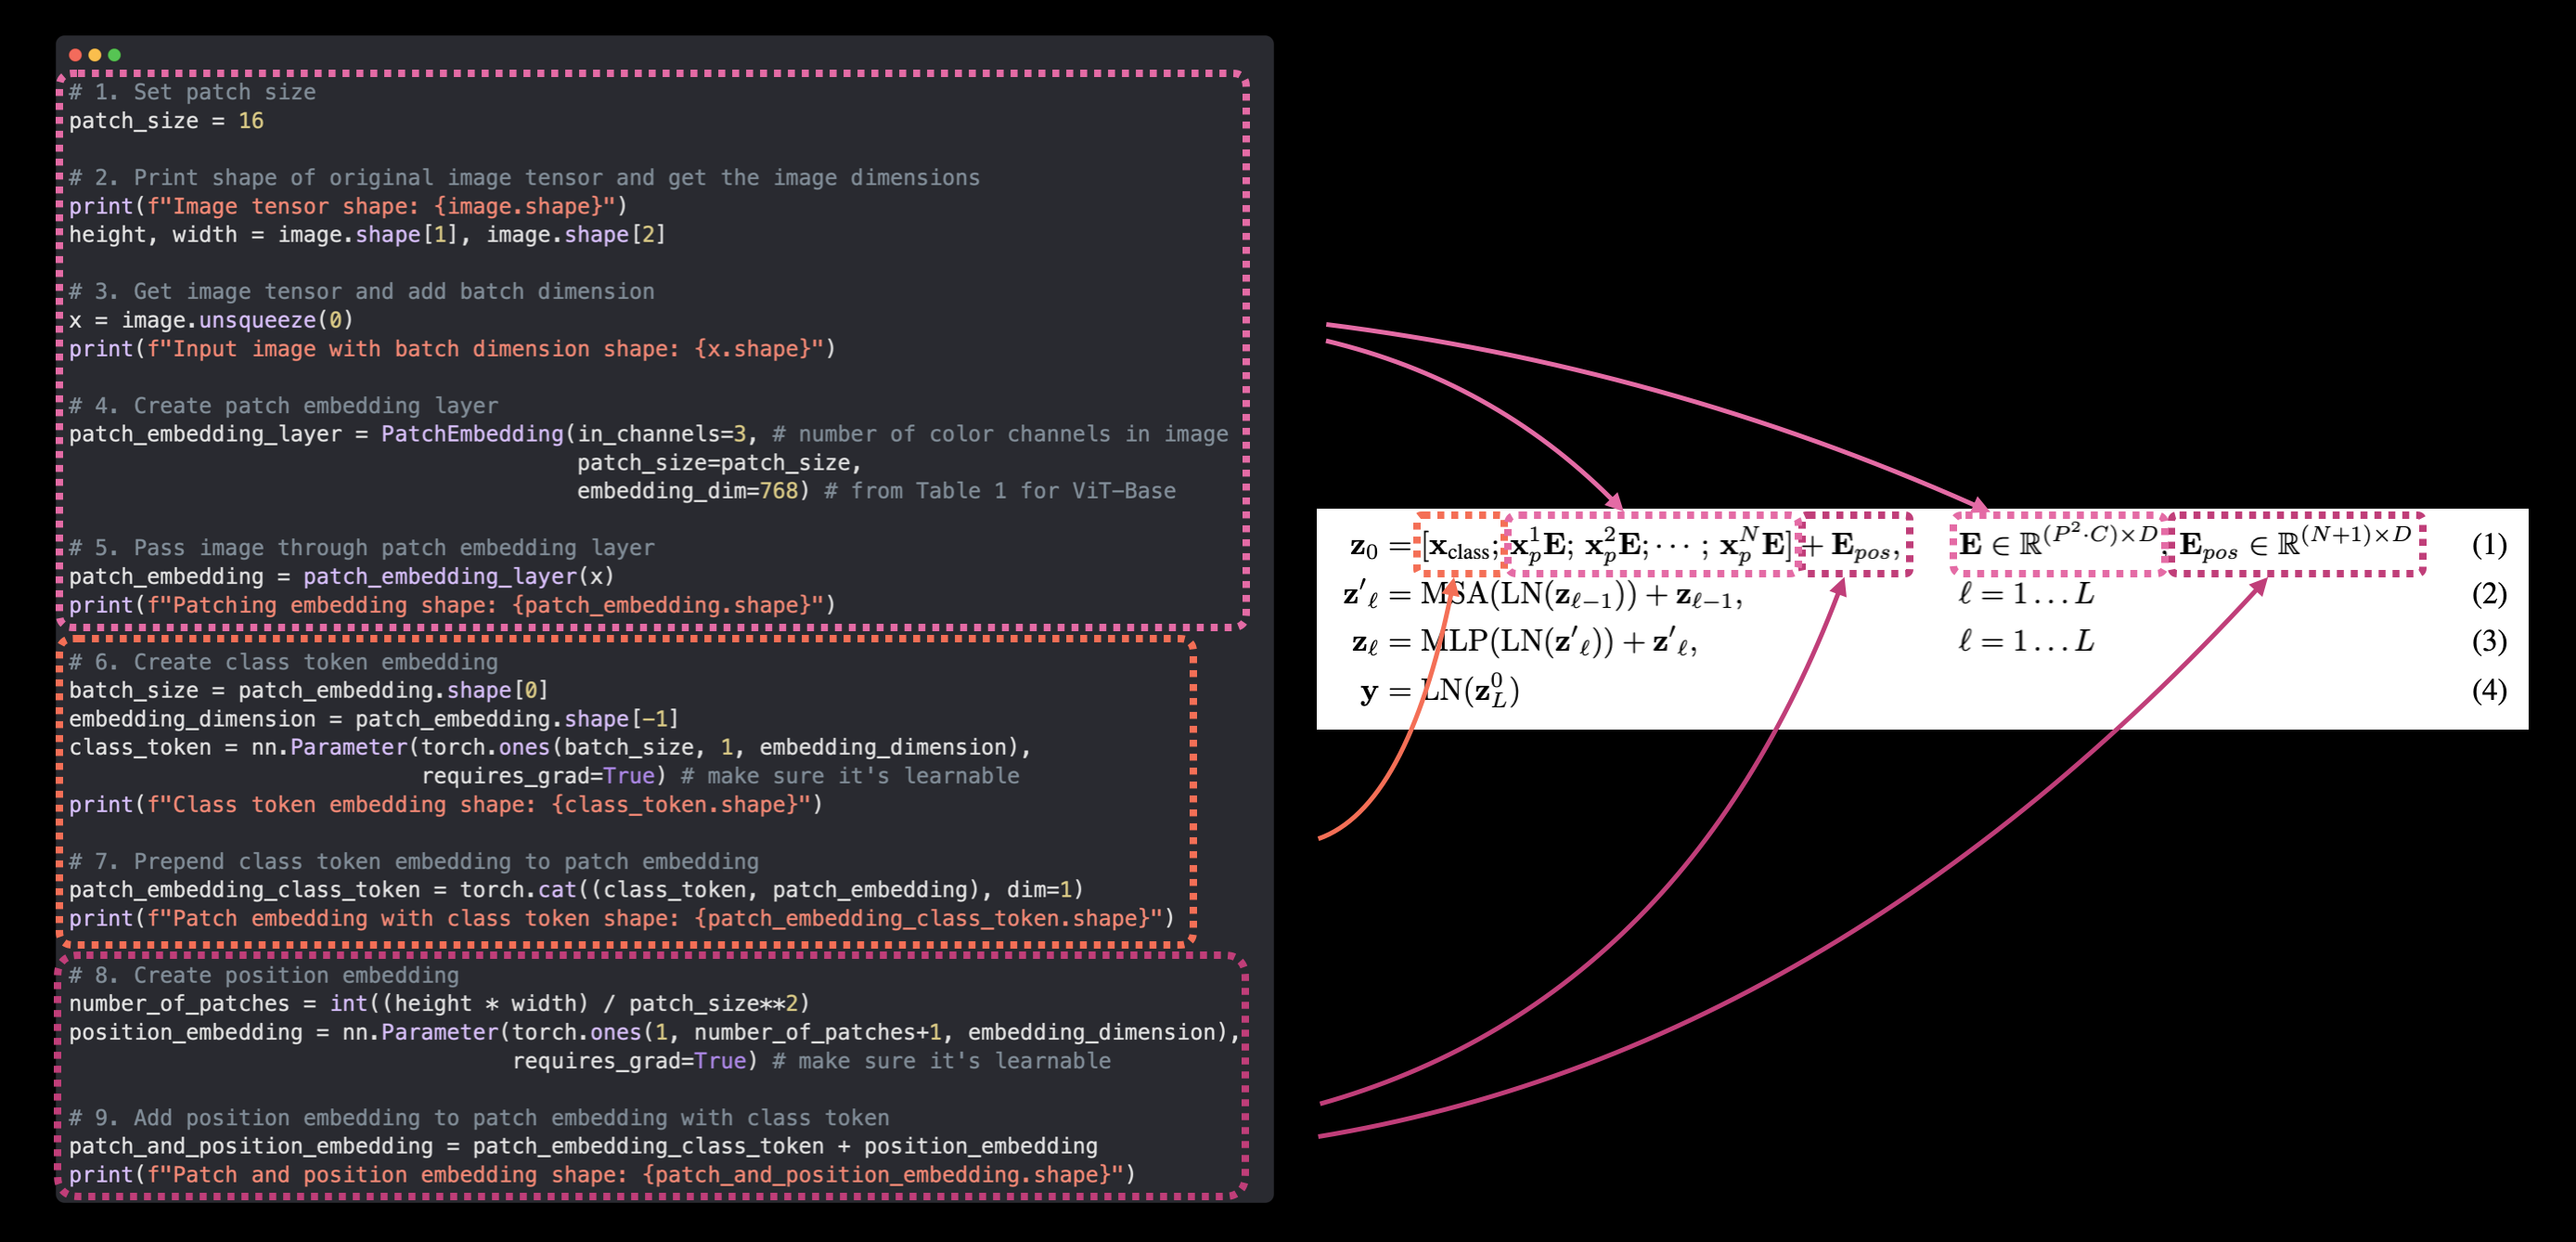

Mapping equation 1 from the ViT paper to our PyTorch code. This is the essence of paper replicating, taking a research paper and turning it into usable code.

Now we've got a way to encode our images and pass them to the Transformer Encoder in Figure 1 of the ViT paper.

Workflow
![gif](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-architecture-animation-full-architecture.gif)

## 5. Equation 2: Multi-Head Attention (MSA)

Recall equation 2 states:

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

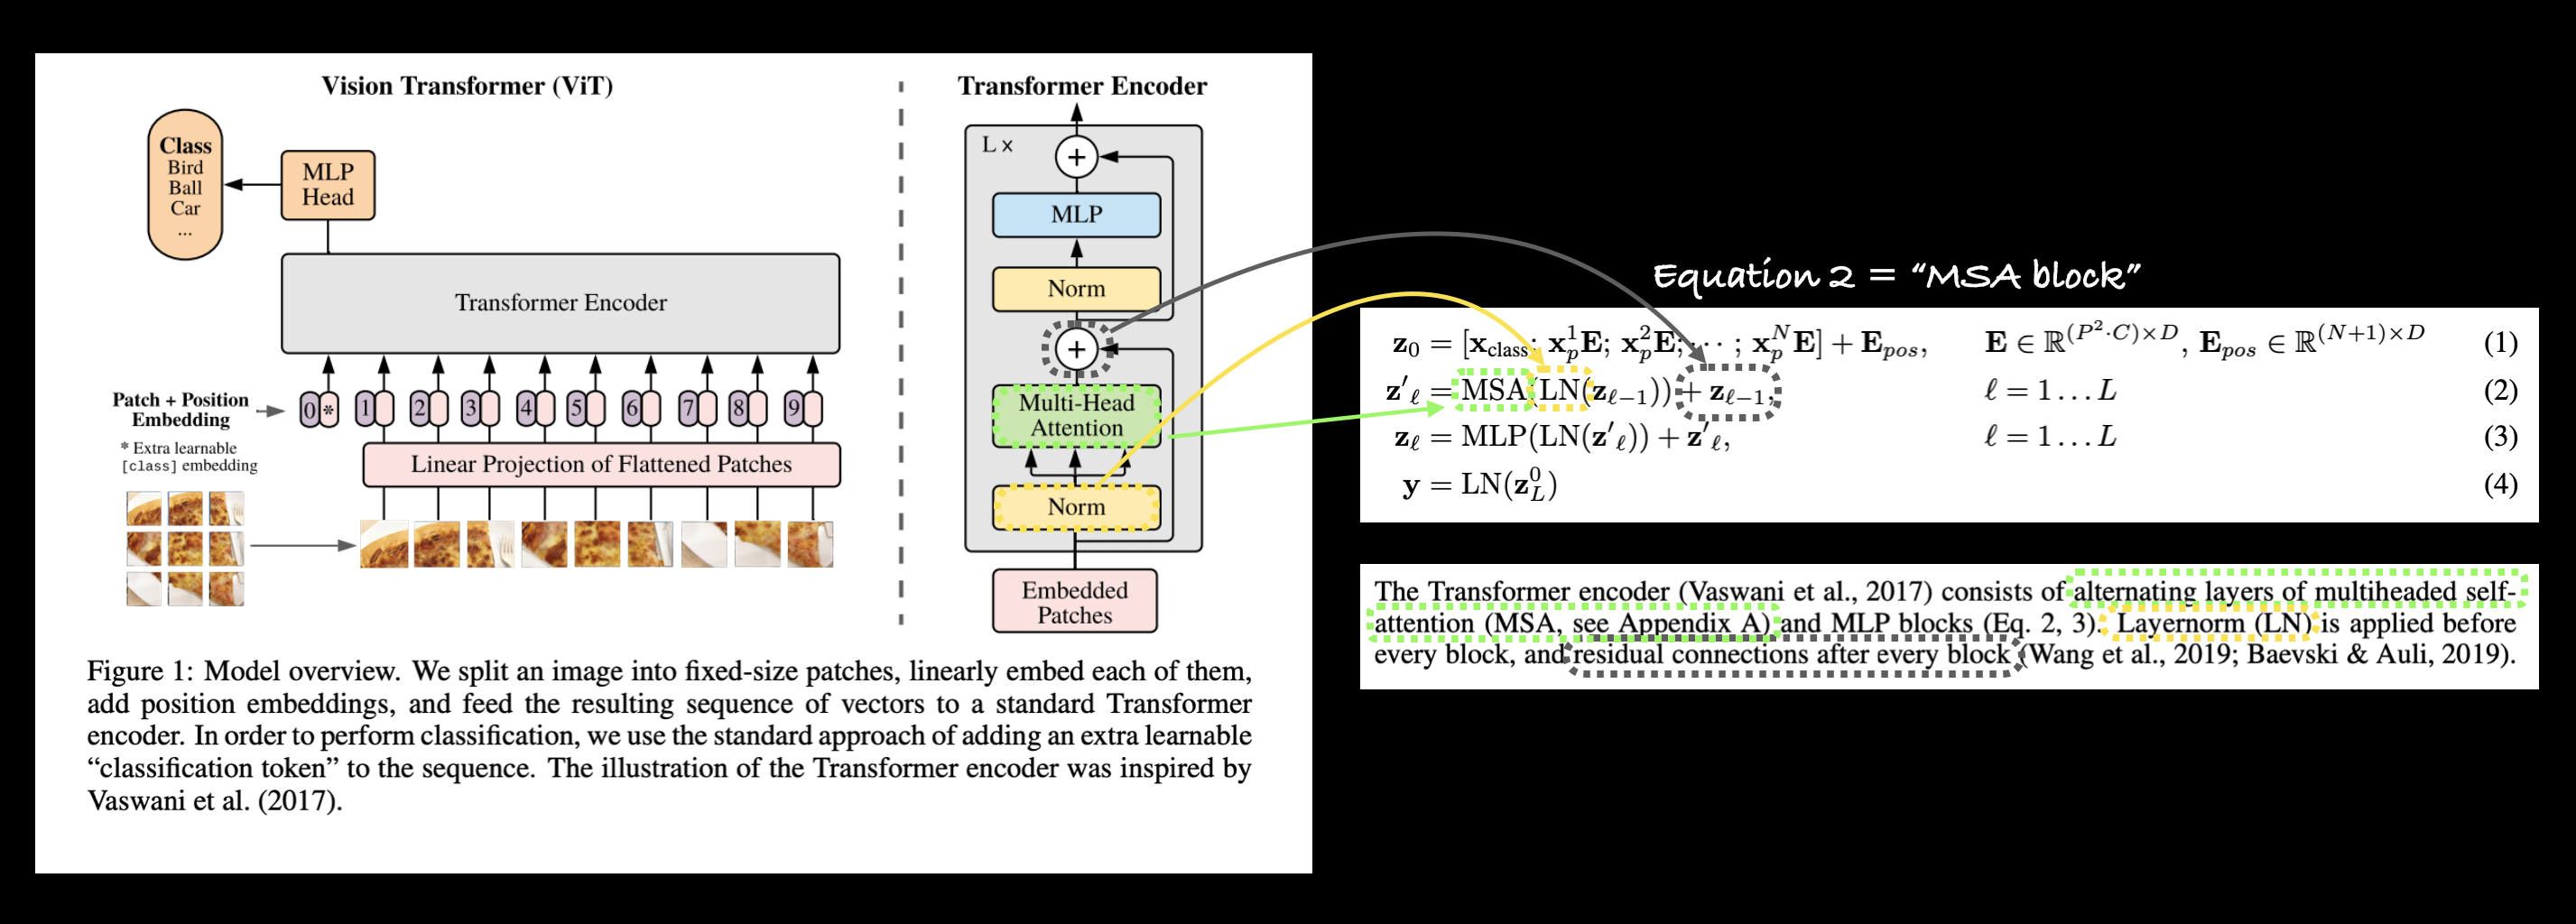


*    Multi-Head Self Attention (MSA) -`torch.nn.MultiheadAttention()`.
*    Norm (LN or LayerNorm) - `torch.nn.LayerNorm()`.
*    Residual connection - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).


### 5.1 The LayerNorm (LN) layer

Layer Normalization (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

used to make training faster.

### 5.2 The Multi-Head Self Attention (MSA) layer

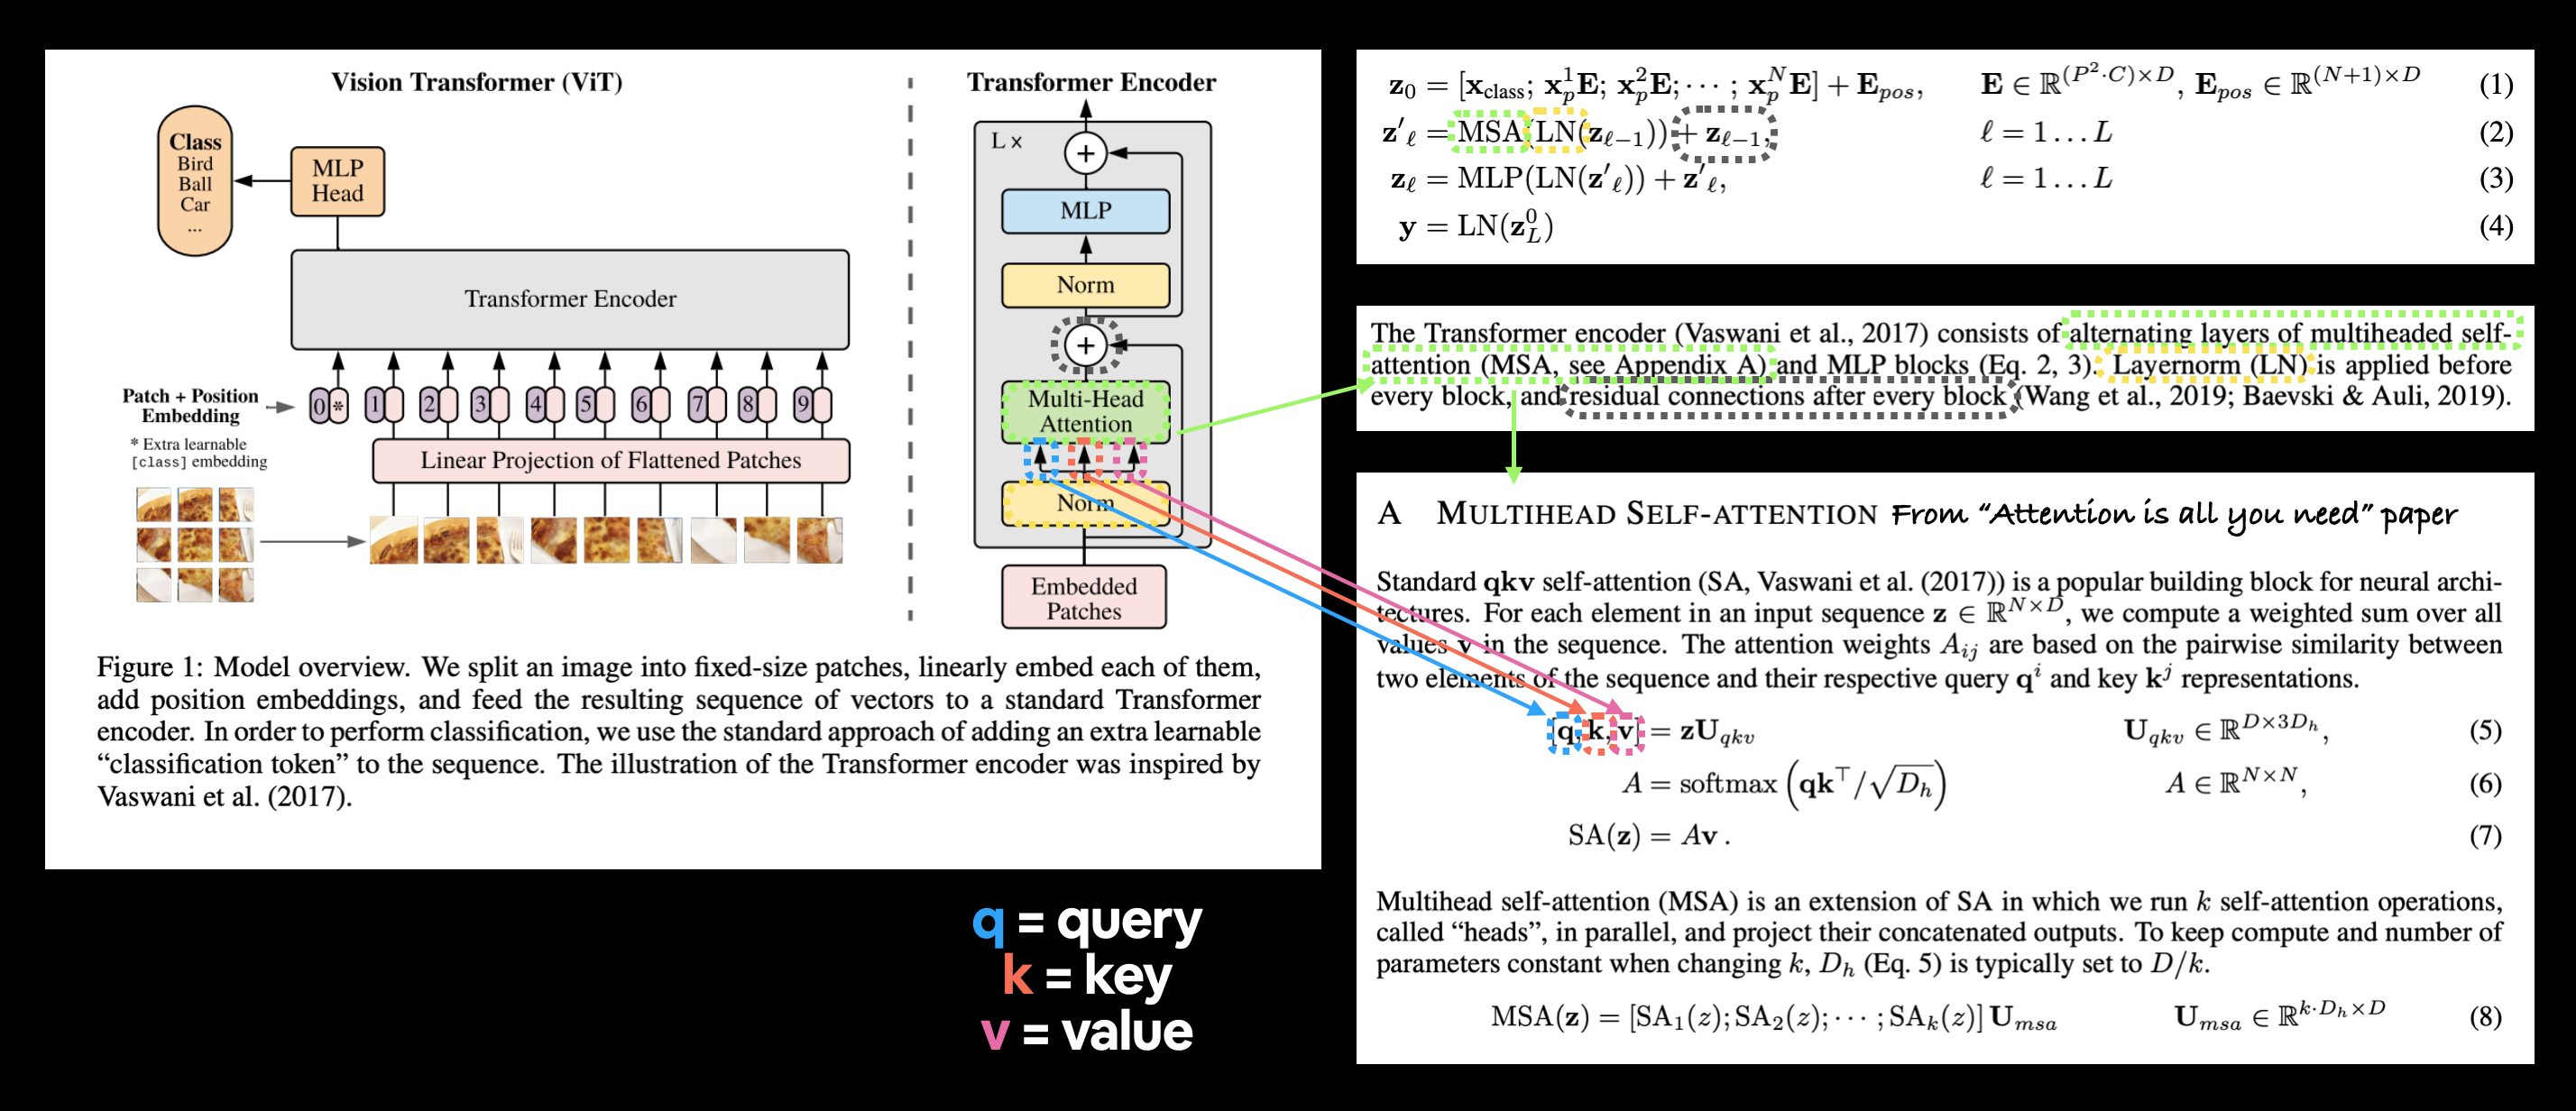

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:

*    embed_dim - the embedding dimension from Table 1 (Hidden size $D$).
*    num_heads - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
*    dropout - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
*    batch_first - does our batch dimension come first? (yes it does)


### 5.3 Replicating Equation 2 With PyTorch layers

to do so, we'll:

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from nn.module
2. initialize class with hyper params from table 1 of ViT paper for the base model
3. Layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension
4. create a multi-head attention (MSA) layer with appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a `forward()` method for our class passing in the inputs through the LN layer and MSA layer.

In [70]:
class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim : int = 768, # hidden size d from table 1
                 num_heads: int = 12, # heads from table 1
                 attn_dropout:float = 0): # paper does not use any
        super().__init__()

        # create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create multi-head attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim= embedding_dim,
                                                    num_heads= num_heads,
                                                    dropout= attn_dropout,
                                                    batch_first= True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights = False)
        
        return attn_output


lets try it out

In [71]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


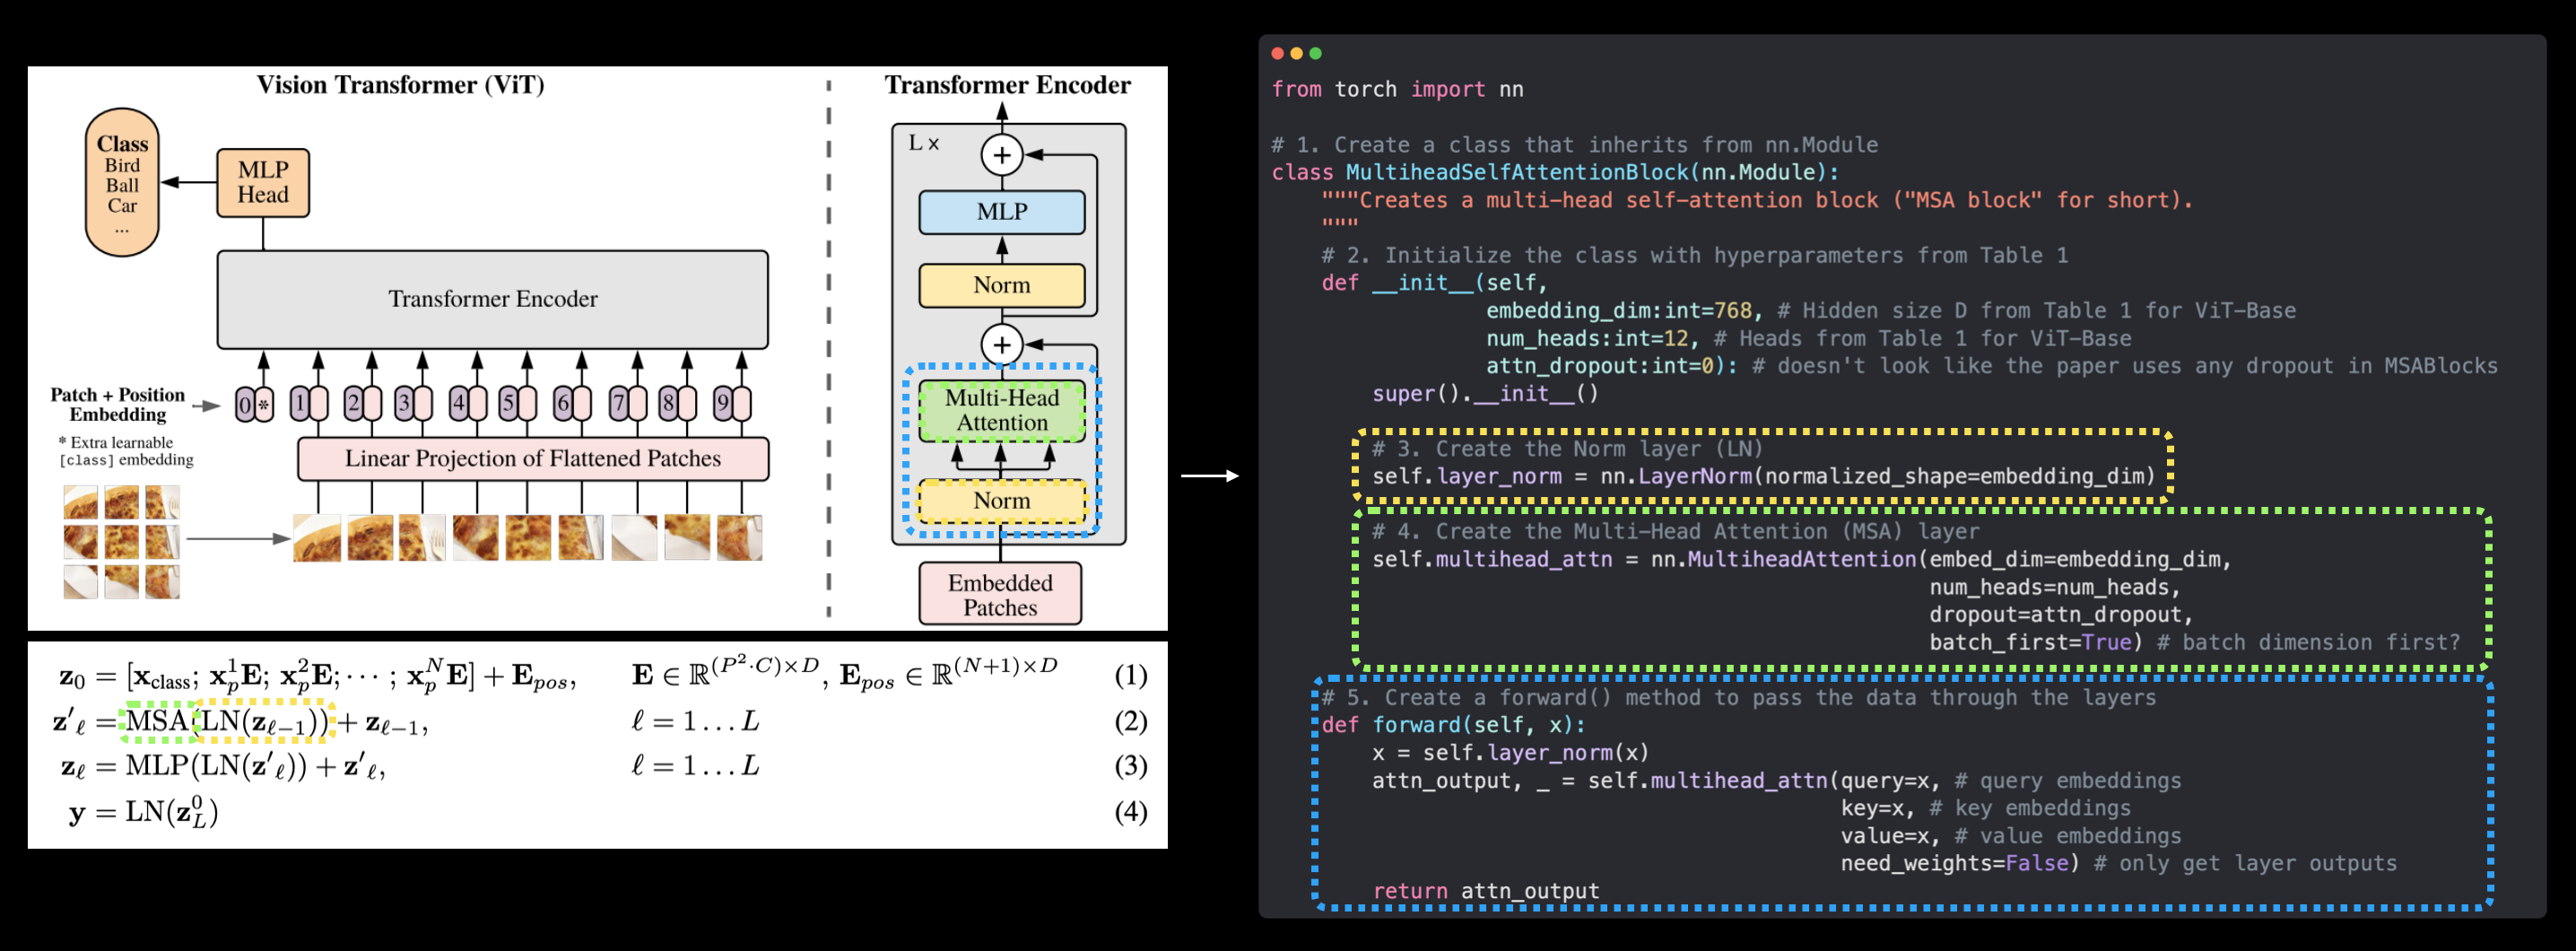

## 6. Equation 3: Multilayer Perceptron (MLP)

replicate equation 3:

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

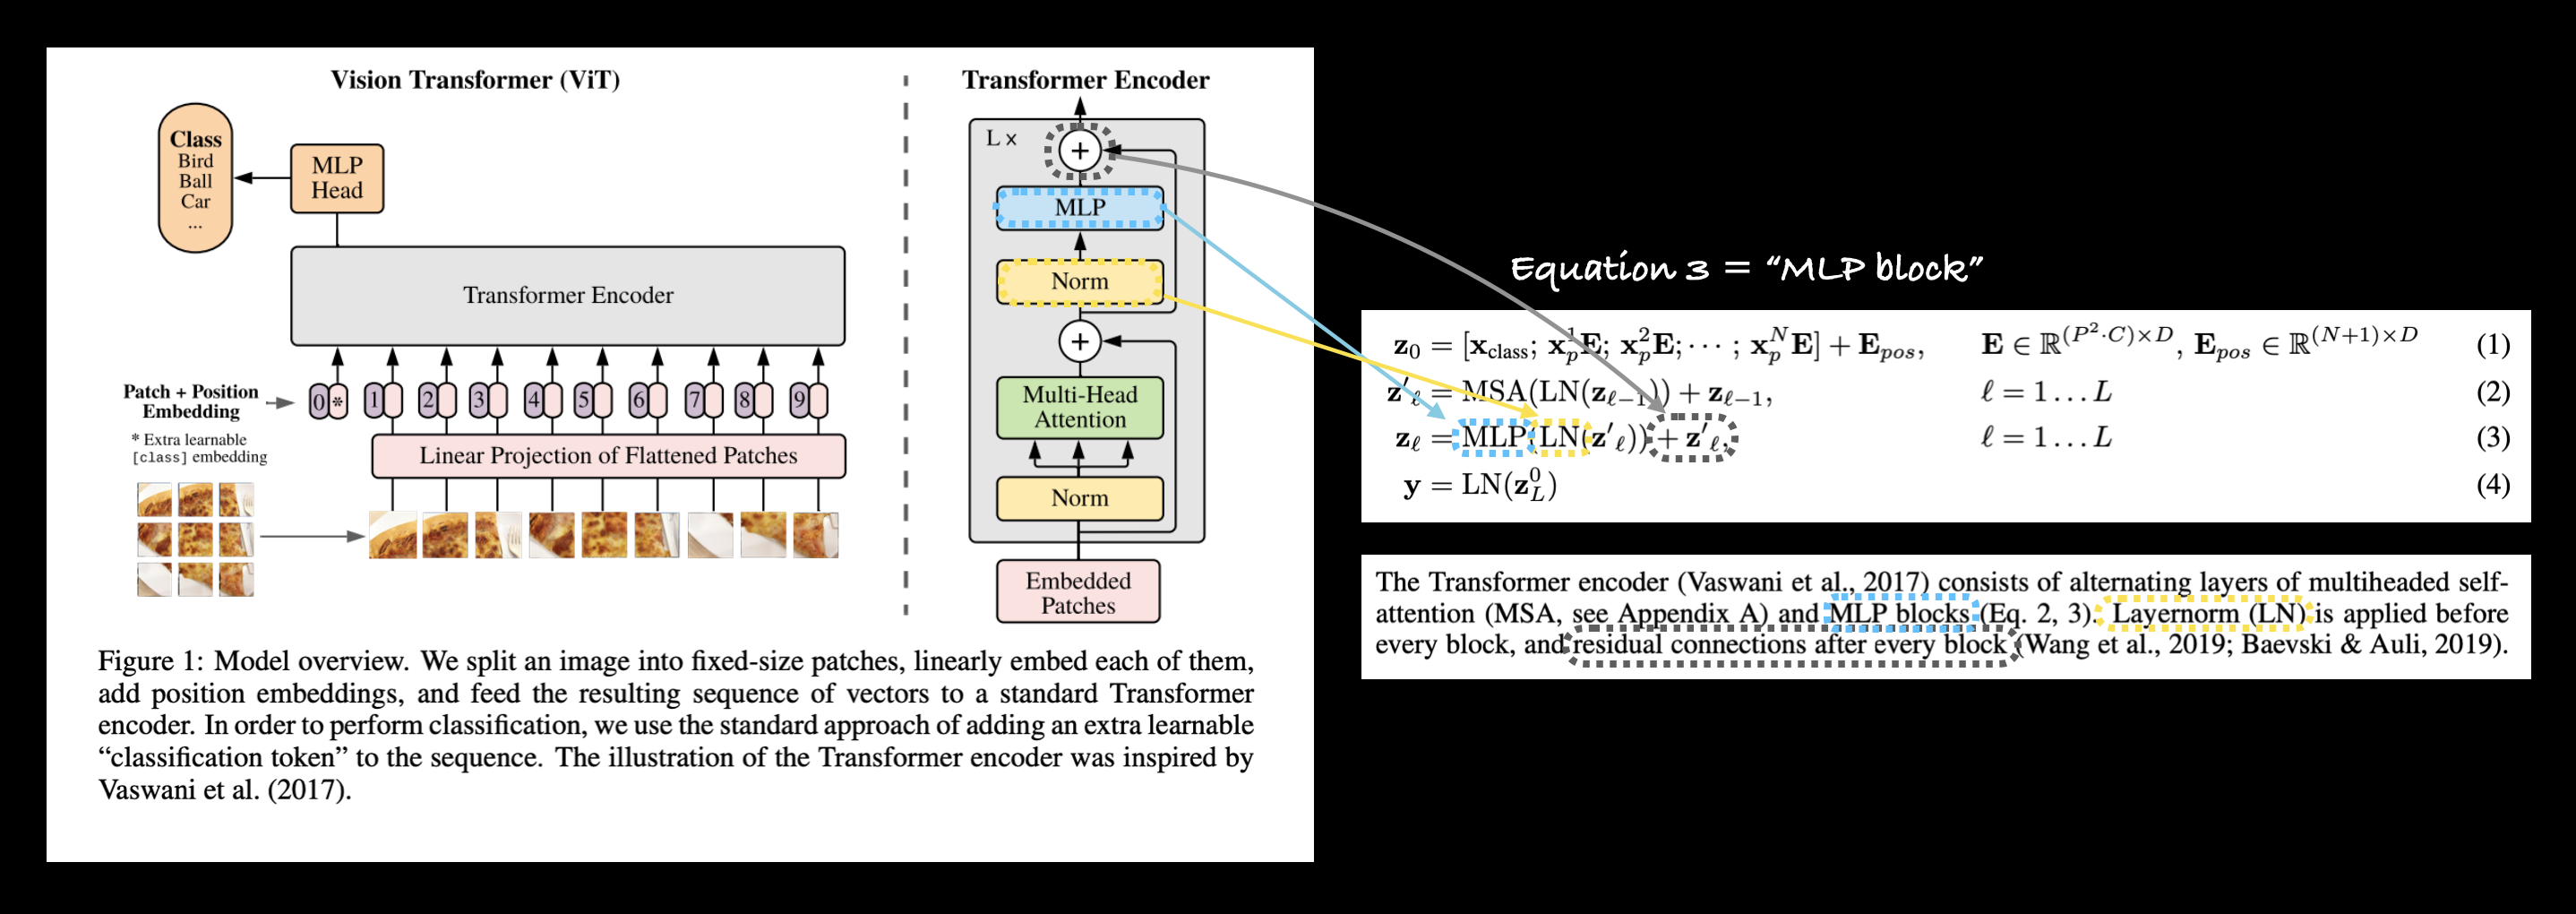

### 6.1 The MLP layer(s)

this generaly means multiple layers 

in ViT paper the MLP structure is:
`2 layers with GELU non-linearity`

`torch.nn.Linear()` and `torch.nn.GELU`

dropout is applied after every dense layer (linear layer) except the qkv projections and directly after adding positional to patch embedding.

the structure is:
`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout

with hyper params from the table 1`

### 6.2 Replicating equation 3 with PyTorch layers

1. Create a class MLPBlock that inherit nn.Module
2. Initialize class with hyperparams of the ViT paper for the ViT base model.
3. create layer normalization with `torch.nn.LayerNorm()` with normalized_shape parameter the same as our embedding dimension
4. Create a sequential series of MLP layers with structure and appropriate hyper params
5. create a forward() method for our class passing in the inputs through LN and MLP layers

In [73]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.1):
        super().__init__()

        # make layer norm
        self.layer_norm = nn.LayerNorm(normalized_shape= embedding_dim)

        # make mlp block 
        self.mlp = nn.Sequential(
            nn.Linear(in_features= embedding_dim,
                      out_features= mlp_size),
                      nn.GELU(),
                      nn.Dropout(p = dropout),
                      nn.Linear(in_features= mlp_size,
                                out_features= embedding_dim),
                      nn.Dropout(p = dropout)
        )

    def forward(self, x):
        # x = self.layer_norm(x)
        # x = self.mlp(x)

        # return x
    
        return self.mlp(self.layer_norm(x))


lets try

In [74]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create the transformer encoder

